In [98]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

%matplotlib inline

# 数据集

In [118]:
series = pd.read_csv(
    "E:/projects/timeseries_forecasting/tsproj/dataset/daily-minimum-temperatures.csv", 
    header = 0,
    index_col = 0,
)
series

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


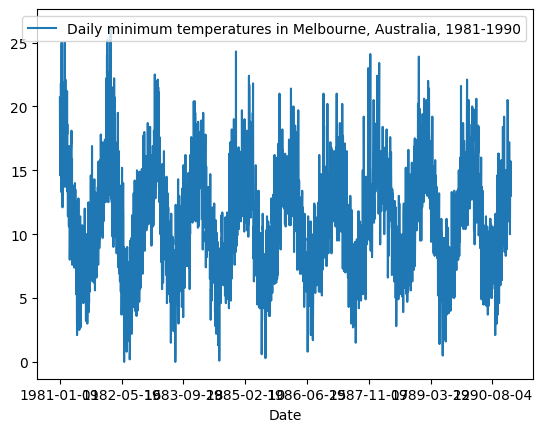

In [120]:
series.plot()
plt.show()

# 快速自相关检查

In [121]:
df = pd.concat([series.shift(1), series], axis = 1)
df.columns = ["t-1", "t+1"]
result = df.corr()
result

,t-1,t+1
t-1,1.00000,0.77487
t+1,0.77487,1.00000


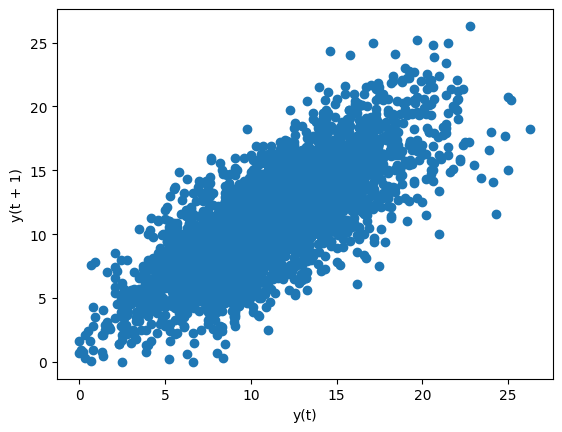

In [122]:
pd.plotting.lag_plot(series)
plt.show()

# 自相关图

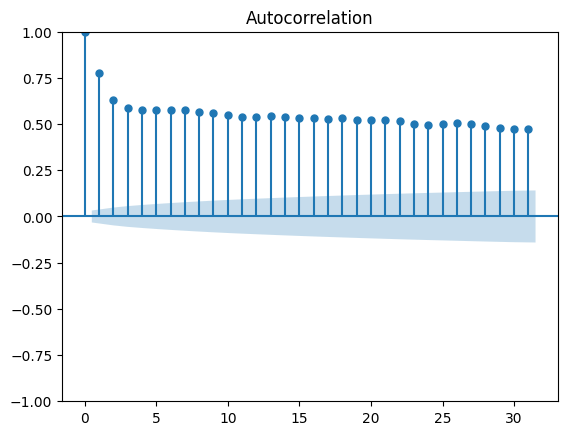

In [123]:
plot_acf(series, lags = 31)
plt.show()

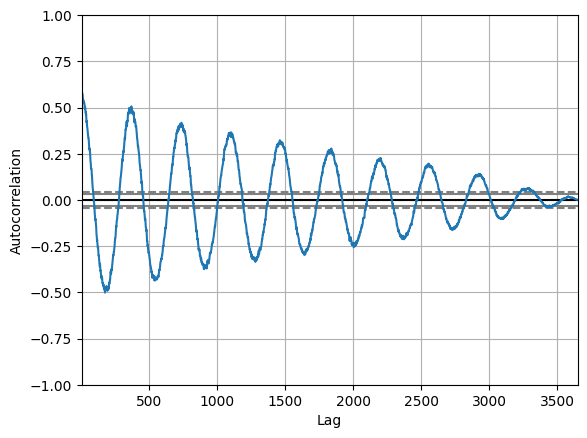

In [124]:
pd.plotting.autocorrelation_plot(series)
plt.show()

# 自回归模型

In [106]:
# data
# series = pd.Series.from_csv("daily-minimum-temperature.csv", header = 0)

In [107]:
# split data
X = series.values
train, test = X[1:(len(X) - 7)], X[(len(X)-7):]
print(train.shape)
print(test.shape)

(3642, 1)
(7, 1)


In [108]:
# model train
model = AutoReg(train, lags = 3)
model_fit = model.fit()

In [110]:
# 滞后长度
window = model_fit.ar_lags[-1]
print(f"Lag: {window}")
# 系数
coef = model_fit.params
print(f"Coefficients: {coef}")

Lag: 3
Coefficients: [ 1.88287666  0.70055426 -0.05985435  0.19052746]


In [111]:
# model prediction
preds = model_fit.predict(
    start = len(train), 
    end = len(train) + len(test) - 1,
    dynamic = False,
)

for i in range(len(preds)):
    print(f"predicted: {preds[i]}, expected: {test[i]}")

error = mean_squared_error(test, preds)
print(f"test MSE: {error:.3f}")

predicted: 10.571406264565157, expected: [12.9]
predicted: 11.338508526152953, expected: [14.6]
predicted: 11.098647056792704, expected: [14.]
predicted: 10.993565260318741, expected: [13.6]
predicted: 11.080460553909838, expected: [13.5]
predicted: 11.101924828676594, expected: [15.7]
predicted: 11.091739689479638, expected: [13.]
test MSE: 8.844


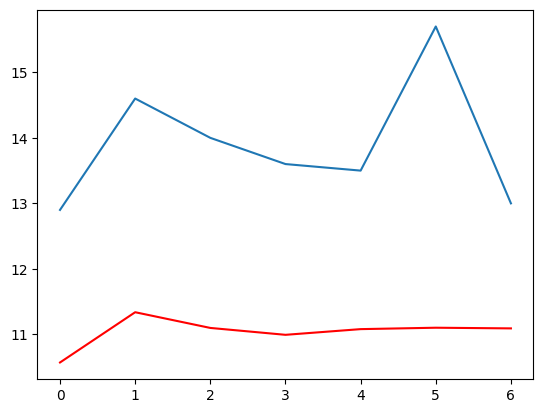

In [112]:
# result plot
plt.plot(test)
plt.plot(preds, color = "red")
plt.show()

predicted=10.571406, expected=12.900000
predicted=12.969815, expected=14.600000
predicted=13.244122, expected=14.000000
predicted=13.274567, expected=13.600000
predicted=13.354155, expected=13.500000
predicted=13.193724, expected=15.700000
predicted=14.664718, expected=13.000000
Test MSE: 2.547


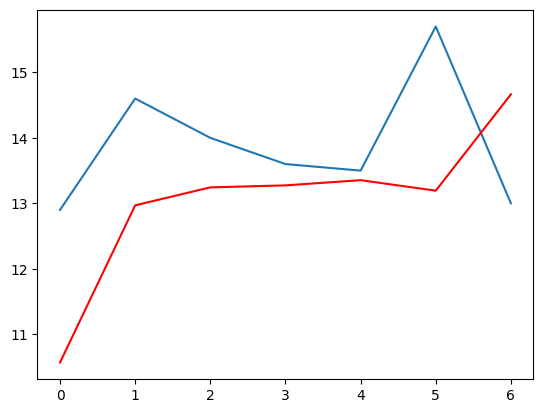

In [116]:
# walk forward over time steps in test
history = train[len(train)-100:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# 持久化模型